# Anomaly detection using classification by type of machine

Nous allons essayer de détecter les sons anormaux pour une machine spécifique en appliquant la méthode suivante :

Entraîner un modèle de machine learning avec le jeu de données d'entraînement afin d'avoir un modèle capable de classer le son par type de machine. Nous testerons plusieurs modèles avec ou sans méthode de réduction des features.

Utiliser le modèle pour prédire le type de machine d'un son et supposer que si le type détecté n'est pas le bon, il peut s'agir d'un son anormal.

## Import des librairies

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
# Python libraries:
# to handle datasets
import numpy as np # linear algebra
import random

# Initialization:
np.random.seed(1001)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import time

from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

# for sound analysis
import librosa
import librosa.display
import IPython.display as ipd
from scipy import fftpack
from scipy import signal

from tqdm.notebook import tqdm

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#show pandas version
pd.__version__

'1.3.0'

## Création du fichier CSV contenant les features

In [2]:
# Paths definition:
ROOT_AUDIO     = './../data' #Directory name where are all wave files
#ROOT_AUDIO     = '/content/drive/MyDrive/DCASE_DATASET/dev' #Directory name where are all wave files
DEV_DATA_PATH       = os.path.join(ROOT_AUDIO, 'dev_data')
EVAL_DATA_PATH      = os.path.join(ROOT_AUDIO, 'eval_data')

def load_sound_file(audio_path, duration=None):
    """
    Loads a sound file
    
    PARAMS
    ======
        audio_path (string) - location to the WAV file to open
    
    RETURNS
    =======
        signal (numpy array) - sound signal
        sampling_rate (float) - sampling rate detected in the file
    """
    multi_channel_data, sampling_rate = librosa.load(audio_path, sr=None, duration=duration)
    signal = np.array(multi_channel_data)
    
    return signal, sampling_rate

def generate_dataset(data_dir):
    """
    Takes a list for WAV files as an input and generate a numpy array with
    the extracted features.
    
    PARAMS
    ======
        data_dir (string) - Root directory to audio files
        
    RETURNS
    =======
        dataset (dataframe) - dataset
    """

    dataset = []
    filepath = []
    
    #create header variable
    header = 'pathname filename machine_id sample_id audio_format machine_type machine_kind data_split condition durations samplingrate'

    header = header.split()
    
    for audioroot, _, audiofiles in os.walk(data_dir):
        print(audioroot)
        for index in tqdm(range(len(audiofiles)), desc='Extracting features'):
            filename = audiofiles[index]
            audiopath = os.path.join(audioroot, filename)
            file_ext = audiopath.split("\\")[-1].split("_")[-1].split(".")[-1]
            if file_ext == 'wav':
                signal, sr = load_sound_file(audiopath)

                # Extract features from this signal:
                machine_id = audiopath.split("\\")[-1].split("_")[2]
                sample_id = audiopath.split("\\")[-1].split("_")[-1].split(".")[0]
                audio_format = file_ext
                machine_type = audiopath.split("\\")[-3]
                if 'toy' in machine_type:
                    machine_kind = 'toys'
                else:
                    machine_kind = 'real_machine'

                data_split = audiopath.split("\\")[-2]
                condition = audiopath.split("\\")[-1].split("_")[0]
                durations = len(signal)/sr #librosa.get_duration(filename=audiopath) #len(signal)/sr
                samplingrate = sr #librosa.get_samplerate(audiopath) #sr
                to_append = f'{audiopath} {filename} {machine_id} {sample_id} {audio_format} {machine_type} {machine_kind} {data_split} {condition} {durations} {samplingrate}'    

                filepath.append(to_append.split())
            
    dataset = pd.DataFrame(filepath, columns=header)

    return dataset

In [11]:
files = ROOT_AUDIO
data_location_csv = os.path.join(ROOT_AUDIO, 'dev_data.csv')

if os.path.exists(data_location_csv):
    print('CSV : Train data already exists, loading from file...')
    with open(data_location_csv, 'rb') as f:
        data_csv = pd.read_csv(f, dtype={"machine_id": "str", "sample_id": "str"});
    print('Done.')
        
else:
    data_csv = generate_dataset(files)
    print('Saving csv training data to disk...')
    data_csv.to_csv(data_location_csv)
#    with open(data_location_csv, 'wb') as f:
#        data_csv.to_csv(f, index=False);
    print('Done.')

CSV : Train data already exists, loading from file...
Done.


In [12]:
train_data = data_csv[data_csv['data_split'] == 'train'].reset_index(drop=True)
test_data = data_csv[data_csv['data_split'] == 'test'].reset_index(drop=True)
print(train_data.shape, test_data.shape)

(20119, 11) (10868, 11)


In [5]:
"""
        n_mels (integer) - number of Mel buckets (default: 64)
        n_fft (integer) - length of the windowed signal to compute the short 
                          Fourier transform on
        hop_length (integer) - window increment when computing STFT
        fmin (integer) - low frequency cutoff point that will be used when generating our Mel spectrograms

"""
n_mels = 64 #128 #64; The number of Mels refers to the number Mel bands, or “bins”, that our Mel scale will be broken up into
n_fft = 2**13 #=2048 2**10 #2**11 #=2048;  2**13 #=8196; The n_fft length of the discrete Fourier transformation window describes the size of the window that will be used when performing each discrete Fourier transformation across the audio signal
hop_length = 2**11 #=512 n_fft // 2 # 2**9 #=512; describes how much this window is to be shifted along the audio signal during each step of STFT processing
#hop_length = 2**12 #=512 n_fft // 2 # 2**9 #=512; describes how much this window is to be shifted along the audio signal during each step of STFT processing
fmin = 20 #The minimum frequency describes the low frequency cutoff point that will be used when generating our Mel spectrograms. We will be using a value of 20 Hz for this parameter since this value represents the bottom of the audible frequency spectrum for most humans.

def mel_features_extractor(file, min_s, resizeaudio=False):
    """
    Compute a mel-scaled spectrogram and generate a vector from music dataset 
    
    PARAMS
    ======
        file (string) - location to the WAV file to open
        min_s (int) - fixed length in second to resize the audio file
        resizeaudio (boolean) - if True we truncate the audio file to min_ms time
        
    RETURNS
    =======
        mel_features (dataframe) - dataset
    """
    if resizeaudio:
        audio, sample_rate = load_sound_file(file, duration=min_s)
    else:
        audio, sample_rate = load_sound_file(file)
        
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_features = librosa.power_to_db(mel, ref=np.max)

    return mel_features

def create_mel_data(data, file, ext, duration=None):
    file = file+'.'+ext
    mel_data_train_location = os.path.join(ROOT_AUDIO, file)

    if os.path.exists(mel_data_train_location):
        print(file + ' already exists, loading from file...')
        with open(mel_data_train_location, 'rb') as f:
            df = pd.read_csv(f,index_col=0);
        print('Done.')
            
    else:
       
        print('Saving ' + file + ' to disk...')
        mel_data = data[['pathname','machine_type','machine_kind','condition']]

        start = time.process_time()
        mel_data['feature'] = mel_data['pathname'].apply(lambda x : mel_features_extractor(x, duration, resizeaudio=True).flatten())
        end = time.process_time()
        duree = end - start
        print(f'The time to extract the feature from mel spectrogram is : {duree} s' )

        featuredf = pd.DataFrame(np.array(mel_data.feature.tolist()))
        featuredf.rename(columns=lambda x : "mel"+str(x), inplace = True)

        df = mel_data.drop('feature', axis=1)
        df = pd.concat([df, featuredf], axis=1)

        df.to_csv(mel_data_train_location)
#        with open(mel_data_train_location, 'wb') as f:
#            df.to_feather(f);
        print('Done.')
        
        del featuredf
        del mel_data
        
    return df

In [6]:
# duration of audio file
duree_min = train_data['durations'].min()
duree_max = train_data['durations'].max()

In [7]:
df_mel_train = create_mel_data(train_data, 'mel_data_train', 'csv', duration=duree_min)
df_mel_train.head()

Saving mel_data_train.csv to disk...
The time to extract the feature from mel spectrogram is : 1460.609375 s
Done.


,pathname,machine_type,machine_kind,condition,mel0,mel1,mel2,mel3,mel4,mel5,...,mel5046,mel5047,mel5048,mel5049,mel5050,mel5051,mel5052,mel5053,mel5054,mel5055
0,./../data\dev_data\fan\train\normal_id_00_0000...,fan,real_machine,normal,-7.258698,-7.602532,-8.426039,-7.787192,-8.569654,-8.430184,...,-31.406336,-31.211357,-31.423897,-31.673838,-31.909369,-31.546535,-31.316668,-31.810347,-31.750673,-31.776308
1,./../data\dev_data\fan\train\normal_id_00_0000...,fan,real_machine,normal,-3.005610,-2.770742,-3.535651,-5.185469,-5.431457,-3.079247,...,-28.757160,-18.429560,-16.933121,-21.595905,-28.042797,-32.348961,-36.925503,-39.641151,-40.889488,-42.119411
2,./../data\dev_data\fan\train\normal_id_00_0000...,fan,real_machine,normal,-6.250508,-4.745953,-4.690793,-3.598133,-3.320447,-2.679466,...,-43.335896,-43.354488,-43.284996,-43.446198,-43.888153,-41.698730,-37.433903,-38.036263,-40.226425,-41.781319
3,./../data\dev_data\fan\train\normal_id_00_0000...,fan,real_machine,normal,-5.893258,-6.028917,-4.725915,-2.875690,-1.380224,-2.418306,...,-23.506855,-23.714352,-24.082567,-24.440357,-24.260136,-24.247971,-23.994457,-24.400270,-25.477829,-25.689127
4,./../data\dev_data\fan\train\normal_id_00_0000...,fan,real_machine,normal,-1.137831,-2.805058,-3.393851,-2.321337,-2.892050,-3.698283,...,-51.892838,-52.041168,-53.059082,-53.238289,-53.287666,-53.395554,-52.004936,-46.446945,-46.547562,-50.047806


In [13]:
df_mel_train.describe()

,mel0,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,mel9,...,mel5046,mel5047,mel5048,mel5049,mel5050,mel5051,mel5052,mel5053,mel5054,mel5055
count,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,2.011900e+04,...,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,2.011900e+04
mean,-1.089668e+01,-1.103907e+01,-1.121877e+01,-1.120632e+01,-1.119838e+01,-1.118664e+01,-1.118186e+01,-1.119258e+01,-1.119814e+01,-1.116503e+01,...,-40.017952,-40.196560,-40.340855,-40.445404,-40.513897,-40.570675,-40.582657,-40.614285,-40.749542,-4.116240e+01
std,7.326549e+00,7.501423e+00,7.712405e+00,7.689125e+00,7.679348e+00,7.663397e+00,7.658545e+00,7.678673e+00,7.680473e+00,7.637519e+00,...,10.425699,10.579123,10.731550,10.841982,10.927761,11.006893,11.059178,11.098479,11.034501,1.078699e+01
min,-3.491665e+01,-3.403731e+01,-3.579427e+01,-3.192482e+01,-3.334327e+01,-3.492790e+01,-3.268508e+01,-3.335953e+01,-3.600356e+01,-3.325408e+01,...,-69.818741,-70.329941,-72.581787,-72.547348,-73.222549,-72.863106,-73.029266,-73.177994,-73.211258,-7.357851e+01
25%,-1.690530e+01,-1.737035e+01,-1.789347e+01,-1.792095e+01,-1.786172e+01,-1.792163e+01,-1.796834e+01,-1.789587e+01,-1.782833e+01,-1.782766e+01,...,-47.261992,-47.926243,-48.402100,-48.748926,-48.940266,-49.037928,-49.206024,-49.279724,-49.369965,-4.954275e+01
50%,-1.077427e+01,-1.084441e+01,-1.081058e+01,-1.085516e+01,-1.091914e+01,-1.076035e+01,-1.080100e+01,-1.075453e+01,-1.074740e+01,-1.079197e+01,...,-40.020355,-40.030045,-40.115845,-40.101463,-40.134384,-40.149895,-40.142273,-40.144661,-40.287109,-4.059555e+01
75%,-3.952623e+00,-3.720757e+00,-3.662792e+00,-3.673167e+00,-3.678077e+00,-3.704585e+00,-3.725798e+00,-3.688059e+00,-3.706660e+00,-3.719124e+00,...,-32.413630,-32.421959,-32.413349,-32.439560,-32.426729,-32.432911,-32.367544,-32.371878,-32.507673,-3.287116e+01
max,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07,...,-2.989787,-2.337233,-4.674046,-5.147617,-5.970686,-4.793719,-2.839342,-4.365743,-4.964659,-2.384186e-07


In [14]:
# suppression des colonnes inutiles : pathname, machine_kind, condition
to_drop = ['pathname', 'machine_kind', 'condition']
df_mel_train = df_mel_train.drop(to_drop,axis=1)
df_mel_train.head()

,machine_type,mel0,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,mel5046,mel5047,mel5048,mel5049,mel5050,mel5051,mel5052,mel5053,mel5054,mel5055
0,fan,-7.258698,-7.602532,-8.426039,-7.787192,-8.569654,-8.430184,-7.888652,-7.379071,-6.997793,...,-31.406336,-31.211357,-31.423897,-31.673838,-31.909369,-31.546535,-31.316668,-31.810347,-31.750673,-31.776308
1,fan,-3.005610,-2.770742,-3.535651,-5.185469,-5.431457,-3.079247,-2.100300,-2.610443,-3.302276,...,-28.757160,-18.429560,-16.933121,-21.595905,-28.042797,-32.348961,-36.925503,-39.641151,-40.889488,-42.119411
2,fan,-6.250508,-4.745953,-4.690793,-3.598133,-3.320447,-2.679466,-2.054123,-3.902577,-5.615540,...,-43.335896,-43.354488,-43.284996,-43.446198,-43.888153,-41.698730,-37.433903,-38.036263,-40.226425,-41.781319
3,fan,-5.893258,-6.028917,-4.725915,-2.875690,-1.380224,-2.418306,-3.280359,-5.590529,-6.761478,...,-23.506855,-23.714352,-24.082567,-24.440357,-24.260136,-24.247971,-23.994457,-24.400270,-25.477829,-25.689127
4,fan,-1.137831,-2.805058,-3.393851,-2.321337,-2.892050,-3.698283,-6.415872,-7.827055,-3.457785,...,-51.892838,-52.041168,-53.059082,-53.238289,-53.287666,-53.395554,-52.004936,-46.446945,-46.547562,-50.047806


In [15]:
# Séparation du dataset en données d'entrainement et de test
target = df_mel_train.machine_type
data = df_mel_train.drop('machine_type',axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.20)

In [16]:
#Standardisation des données
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Essai d'un classifier de type SVM

In [17]:
# entrainement d'un classifier SVM
start_time = time.time()
clf = svm.SVC(gamma = 0.01, kernel = 'poly')
clf.fit(X_train_scaled,y_train)

# prédiction et résultats du modèle
y_pred = clf.predict(X_test_scaled)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,786,0,0,0,0,0
ToyConveyor,2,614,0,1,0,0
fan,0,0,695,12,10,4
pump,1,0,28,601,28,8
slider,0,0,34,36,459,11
valve,0,0,6,17,12,659


In [18]:
# calcul de la précision sans PCA
print('Score : ', clf.score(X_test_scaled,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.9478131212723658
--- 174.7274672985077 seconds ---


In [20]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       1.00      1.00      1.00       786
 ToyConveyor       1.00      1.00      1.00       617
         fan       0.91      0.96      0.94       721
        pump       0.90      0.90      0.90       666
      slider       0.90      0.85      0.88       540
       valve       0.97      0.95      0.96       694

    accuracy                           0.95      4024
   macro avg       0.95      0.94      0.94      4024
weighted avg       0.95      0.95      0.95      4024



La classification fonctionne correctement mais les types de machine Slider et Pump sont moins bien détectées.

## Essai avec une réduction de features de type PCA

In [60]:
pca = PCA(n_components = 0.9)
X_train_pca_scaled = pca.fit_transform(X_train_scaled)
X_test_pca_scaled = pca.transform(X_test_scaled)
print("Nombre de composantes retenues :", pca.n_components_)

Nombre de composantes retenues : 40


La réduction de features permet de passer de 5056 features à 40.

In [22]:
# Classifier SVM avec les features réduites
start_time = time.time()
clf = svm.SVC(gamma = 0.01, kernel = 'poly')
clf.fit(X_train_pca_scaled,y_train)
y_pred = clf.predict(X_test_pca_scaled)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,786,0,0,0,0,0
ToyConveyor,0,616,0,1,0,0
fan,0,0,666,25,27,3
pump,0,0,43,586,34,3
slider,0,0,46,64,416,14
valve,0,0,14,30,23,627


In [23]:
# calcul de la précision avec PCA
print ('Score : ',clf.score(X_test_pca_scaled,y_test))
print("--- %s seconds ---" % end_time)
# le score est un peu moins bon qu'avec toutes les features

Score :  0.9187375745526839
--- 8.152308225631714 seconds ---


In [24]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       1.00      1.00      1.00       786
 ToyConveyor       1.00      1.00      1.00       617
         fan       0.87      0.92      0.89       721
        pump       0.83      0.88      0.85       666
      slider       0.83      0.77      0.80       540
       valve       0.97      0.90      0.94       694

    accuracy                           0.92      4024
   macro avg       0.92      0.91      0.91      4024
weighted avg       0.92      0.92      0.92      4024



L'utilisation de la réduction de features permet d'entrainer le modèle beaucoup plus rapidement car on passe de 180 secondes d'apprentissage à 9 secondes, mais dégrade un peu la précision du modèle de 94,8% à 91.8%.

Ce sont principalement la classification des types fan, pump, slider et valve qui est dégradée.

## KNN sans PCA

Nous allons tester un modèle KNN sans réduction de features

In [26]:
start_time = time.time()
knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,786,0,0,0,0,0
ToyConveyor,6,611,0,0,0,0
fan,1,0,675,24,21,0
pump,0,0,177,442,47,0
slider,0,0,181,82,267,10
valve,0,0,112,74,43,465


In [27]:
# calcul de la précision du classifier KNN
print ('Score : ',knn.score(X_test,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.8066600397614314
--- 3.9606306552886963 seconds ---


In [28]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       0.99      1.00      1.00       786
 ToyConveyor       1.00      0.99      1.00       617
         fan       0.59      0.94      0.72       721
        pump       0.71      0.66      0.69       666
      slider       0.71      0.49      0.58       540
       valve       0.98      0.67      0.80       694

    accuracy                           0.81      4024
   macro avg       0.83      0.79      0.80      4024
weighted avg       0.83      0.81      0.81      4024



Le modèle KNN est moins performant que le SVM, on passe de 94% à 80% de précision.

## KNN avec PCA

In [30]:
pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("Nombre de composantes retenues :", pca.n_components_)

Nombre de composantes retenues : 26


In [31]:
start_time = time.time()
knn_pca = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn_pca.fit(X_train_pca, y_train)
y_pred = knn_pca.predict(X_test_pca)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,785,1,0,0,0,0
ToyConveyor,2,615,0,0,0,0
fan,1,0,635,45,40,0
pump,0,0,100,499,67,0
slider,0,0,104,81,332,23
valve,0,0,45,70,54,525


In [32]:
# calcul de la précision du classifier KNN
print ('Score : ',knn_pca.score(X_test_pca,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.8426938369781312
--- 1.0558795928955078 seconds ---


In [33]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       1.00      1.00      1.00       786
 ToyConveyor       1.00      1.00      1.00       617
         fan       0.72      0.88      0.79       721
        pump       0.72      0.75      0.73       666
      slider       0.67      0.61      0.64       540
       valve       0.96      0.76      0.85       694

    accuracy                           0.84      4024
   macro avg       0.84      0.83      0.83      4024
weighted avg       0.85      0.84      0.84      4024



En utilisant une réduction de features on améliore le modèle KNN mais qui reste moins bon que le modèle SVM

## Essai d'un classifier de type Arbre de Décisions

In [34]:
start_time = time.time()
dt_clf = DecisionTreeClassifier(criterion='entropy',max_depth=4)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,valve
Classe réelle,,,,
ToyCar,761,18,7,0
ToyConveyor,83,515,18,1
fan,2,2,649,68
pump,3,2,579,82
slider,1,2,410,127
valve,3,1,312,378


In [35]:
print ('Score : ',dt_clf.score(X_test,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.5723161033797217
--- 57.75168776512146 seconds ---


In [36]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       0.89      0.97      0.93       786
 ToyConveyor       0.95      0.83      0.89       617
         fan       0.33      0.90      0.48       721
        pump       0.00      0.00      0.00       666
      slider       0.00      0.00      0.00       540
       valve       0.58      0.54      0.56       694

    accuracy                           0.57      4024
   macro avg       0.46      0.54      0.48      4024
weighted avg       0.48      0.57      0.50      4024



Le modèle Arbre de Décisions est encore moins bon que le modèle KNN, on obtient ici une précision de 57 % et les types de machine pump et slider ne sont pas du tout détectées correctement

## Essai d'un classifier de type Random Forrest

In [37]:
start_time = time.time()
rf = ensemble.RandomForestClassifier (n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
end_time = time.time() - start_time

In [38]:
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,778,8,0,0,0,0
ToyConveyor,1,616,0,0,0,0
fan,0,0,667,23,25,6
pump,1,1,50,563,38,13
slider,0,0,35,46,415,44
valve,0,0,5,11,4,674


In [39]:
print ('Score : ',rf.score(X_test,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.922713717693837
--- 7.790278434753418 seconds ---


In [40]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       1.00      0.99      0.99       786
 ToyConveyor       0.99      1.00      0.99       617
         fan       0.88      0.93      0.90       721
        pump       0.88      0.85      0.86       666
      slider       0.86      0.77      0.81       540
       valve       0.91      0.97      0.94       694

    accuracy                           0.92      4024
   macro avg       0.92      0.92      0.92      4024
weighted avg       0.92      0.92      0.92      4024



Le modèle Radom Forrest est très proche du modèle SVM en terme de précision.

Nous allons essayer d'optimiser les modèle SVM avec réduction de features et Random Forrest

## Gridsearch sur SVM avec PCA

Nous allons faire varier les hyper paramètres du modèle SVM pour l'optimiser

In [42]:
clf_svc = svm.SVC()

param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                       {'kernel': ['linear'], 'C': np.logspace(-4, 1, 6)},
                     {'kernel': ['poly'], 'C': np.logspace(-4, 4, 9)}]
gridcv = GridSearchCV(estimator=clf_svc, param_grid=param_grid_svc,verbose=2, n_jobs = -1)
gridcv.fit(X_train_pca_scaled,y_train)

print(pd.DataFrame(gridcv.cv_results_).loc[:,['params', 'mean_test_score', 'std_test_score']])

Fitting 5 folds for each of 51 candidates, totalling 255 fits
                                               params  mean_test_score  \
0     {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}         0.199689   
1   {'C': 0.0001, 'gamma': 0.002154434690031882, '...         0.199689   
2   {'C': 0.0001, 'gamma': 0.046415888336127774, '...         0.199689   
3        {'C': 0.0001, 'gamma': 1.0, 'kernel': 'rbf'}         0.199689   
4      {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}         0.307052   
5   {'C': 0.001, 'gamma': 0.002154434690031882, 'k...         0.199689   
6   {'C': 0.001, 'gamma': 0.046415888336127774, 'k...         0.199689   
7         {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}         0.199689   
8       {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}         0.594719   
9   {'C': 0.01, 'gamma': 0.002154434690031882, 'ke...         0.447717   
10  {'C': 0.01, 'gamma': 0.046415888336127774, 'ke...         0.199689   
11         {'C': 0.01, 'gamma': 1.0, 'kernel': 'rb

In [43]:
print(gridcv.best_params_)
print(gridcv.best_score_)

{'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.946318732525629


In [44]:
start_time = time.time()
clf_svc = svm.SVC(kernel = 'rbf', gamma = 0.0001, C = 100)
clf_svc.fit(X_train_pca_scaled,y_train)
y_pred = clf_svc.predict(X_test_pca_scaled)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,786,0,0,0,0,0
ToyConveyor,0,617,0,0,0,0
fan,0,0,692,12,14,3
pump,0,0,29,596,34,7
slider,0,0,35,35,453,17
valve,0,0,4,9,26,655


In [45]:
print ('Score : ',clf_svc.score(X_test_pca_scaled,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.9440854870775348
--- 2.7348616123199463 seconds ---


In [46]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       1.00      1.00      1.00       786
 ToyConveyor       1.00      1.00      1.00       617
         fan       0.91      0.96      0.93       721
        pump       0.91      0.89      0.90       666
      slider       0.86      0.84      0.85       540
       valve       0.96      0.94      0.95       694

    accuracy                           0.94      4024
   macro avg       0.94      0.94      0.94      4024
weighted avg       0.94      0.94      0.94      4024



L'optimisation a permis de faire progresser la précision du modèle avec réduction de features de 91,8% à 94,4%

## Gridsearch sur RandomForest

In [47]:
rf = ensemble.RandomForestClassifier ()
param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid,verbose=2, n_jobs = -1)
CV_rf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100]},
             verbose=2)

In [48]:
print(CV_rf.best_params_)
print(CV_rf.best_score_)

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}
0.917614165890028


In [49]:
start_time = time.time()
rf = ensemble.RandomForestClassifier (n_estimators = 100, criterion = 'entropy', max_features='auto' ,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
end_time = time.time() - start_time
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,780,6,0,0,0,0
ToyConveyor,3,614,0,0,0,0
fan,0,0,677,27,12,5
pump,0,1,49,558,41,17
slider,0,0,54,48,397,41
valve,0,0,4,7,3,680


In [50]:
print ('Score : ',rf.score(X_test,y_test))
print("--- %s seconds ---" % end_time)

Score :  0.9209741550695825
--- 14.954603433609009 seconds ---


In [51]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ToyCar       1.00      0.99      0.99       786
 ToyConveyor       0.99      1.00      0.99       617
         fan       0.86      0.94      0.90       721
        pump       0.87      0.84      0.85       666
      slider       0.88      0.74      0.80       540
       valve       0.92      0.98      0.95       694

    accuracy                           0.92      4024
   macro avg       0.92      0.91      0.91      4024
weighted avg       0.92      0.92      0.92      4024



## Chargement des données de test

In [52]:
# duration of audio file
duree_min = test_data['durations'].min()
duree_max = test_data['durations'].max()

#création ou chargement du dataset avec les données de test
df_mel_test = create_mel_data(test_data, 'mel_data_test', 'csv', duration=duree_min)

# suppression des colonnes inutiles : pathname, machine_kind, condition
to_drop = ['pathname', 'machine_kind', 'condition']
df_mel_test_ft = df_mel_test.drop(to_drop,axis=1)
df_mel_test_ft.head()

# Séparation du dataset en données d'entrainement et de test
target = df_mel_test_ft.machine_type
data = df_mel_test_ft.drop('machine_type',axis=1)

Saving mel_data_test.csv to disk...
The time to extract the feature from mel spectrogram is : 781.59375 s
Done.


## Prédiction avec le modèle SVM

Nous allons essayer de prédire l'aspect normal ou anormal d'un son de machine en utilisant le modèle SVM avec réduction de features optimisé

On prédit en premier le type de machine à partir des sons du datatset de test qui contient des sons normaux et anormaux

In [62]:
date_scaled = scaler.transform(data)
date_scaled_PCA = pca.transform(date_scaled)
y_pred_SVC = clf_svc.predict(date_scaled_PCA)
pd.crosstab(target, y_pred_SVC, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,2459,0,0,0,0,0
ToyConveyor,1,3508,0,0,0,0
fan,0,0,1527,223,104,21
pump,0,0,123,668,40,25
slider,0,0,56,117,1074,43
valve,0,0,22,45,63,749


On construit une colonne contenant la prédiction de normalité fondée sur la règle suivante :

si la détection du type de machine est juste on suppose que le son est normal

si la détection est fausse on suppose que le son est anormal

In [63]:
result_SVC = pd.concat([df_mel_test, pd.Series(y_pred_SVC).rename('Predict_type')], axis=1)
result_SVC.loc[result_SVC['machine_type'] == result_SVC['Predict_type'], 'Predict_condition'] = 'normal'  
result_SVC.loc[result_SVC['machine_type'] != result_SVC['Predict_type'], 'Predict_condition'] = 'anomaly'
pd.crosstab(result_SVC.condition, result_SVC.Predict_condition, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,anomaly,normal
Classe réelle,,
anomaly,769,4700
normal,114,5285


Visualisons la prédiction par type de machine

In [65]:
pd.crosstab(index=[result_SVC.machine_type, result_SVC.condition], columns=result_SVC.Predict_condition)

Predict_condition       anomaly  normal
machine_type condition                 
ToyCar       anomaly          0    1059
             normal           0    1400
ToyConveyor  anomaly          1    1109
             normal           0    2399
fan          anomaly        330    1145
             normal          18     382
pump         anomaly        168     288
             normal          20     380
slider       anomaly        156     734
             normal          60     340
valve        anomaly        114     365
             normal          16     384

Il semble qu'il y ait une très mauvaise détection sur les types de machines ToyCar et ToyConvoyer

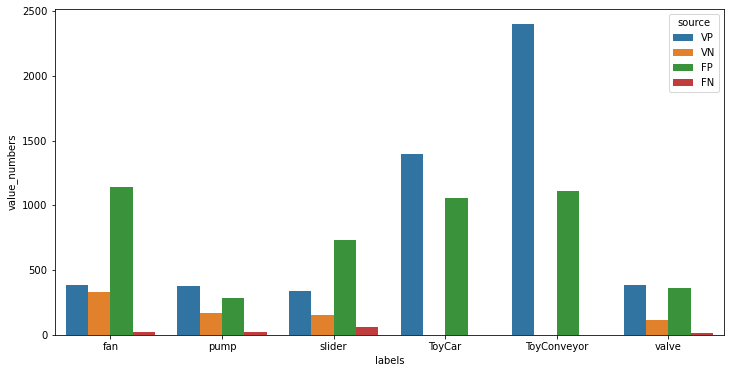

In [66]:
colonne = result_SVC.machine_type.unique().tolist()

dict_analyse = {}
VP, VN, FP, FN = [], [], [], []
for col in colonne:
    VP.append (result_SVC [(result_SVC['condition'] == "normal" ) & (result_SVC['Predict_condition'] == "normal") & (result_SVC['machine_type'] == col) ].shape[0])
    VN.append (result_SVC [(result_SVC['condition'] == "anomaly" ) & (result_SVC['Predict_condition'] == "anomaly") & (result_SVC['machine_type'] == col) ].shape[0])
    FP.append (result_SVC [(result_SVC['condition'] == "anomaly" ) & (result_SVC['Predict_condition'] == "normal") & (result_SVC['machine_type'] == col) ].shape[0])
    FN.append (result_SVC [(result_SVC['condition'] == "normal" ) & (result_SVC['Predict_condition'] == "anomaly") & (result_SVC['machine_type'] == col) ].shape[0])
    
dict_analyse ['labels'] = colonne
dict_analyse ['VP'] = VP
dict_analyse ['VN'] = VN
dict_analyse ['FP'] = FP
dict_analyse ['FN'] = FN

analyse = pd.DataFrame(dict_analyse)

columns = ["labels", "VP", "VN", "FP", "FN"]
analyse_melted = pd.melt(analyse, id_vars=columns[0], var_name="source", value_name="value_numbers")
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x=columns[0], y="value_numbers", hue="source", data=analyse_melted)
plt.show()

## Prédiction avec le modèle RandomForest

Nous allons essayer de prédire l'aspect normal ou anormal d'un son de machine en utilisant le modèle Random Forrest optimisé

In [69]:
y_pred_rf = rf.predict(data)
pd.crosstab(target, y_pred_rf, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,ToyCar,ToyConveyor,fan,pump,slider,valve
Classe réelle,,,,,,
ToyCar,2438,21,0,0,0,0
ToyConveyor,4,3505,0,0,0,0
fan,1,0,1466,225,151,32
pump,6,0,143,631,47,29
slider,0,0,64,122,848,256
valve,1,0,8,7,4,859


In [70]:
result_rf = pd.concat([df_mel_test, pd.Series(y_pred_rf).rename('Predict_type')], axis=1)
result_rf.loc[result_rf['machine_type'] == result_rf['Predict_type'], 'Predict_condition'] = 'normal'  
result_rf.loc[result_rf['machine_type'] != result_rf['Predict_type'], 'Predict_condition'] = 'anomaly'
pd.crosstab(result_rf.condition, result_rf.Predict_condition, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,anomaly,normal
Classe réelle,,
anomaly,921,4548
normal,200,5199


In [71]:
pd.crosstab(index=[result_rf.machine_type, result_rf.condition], columns=result_rf.Predict_condition)

Predict_condition       anomaly  normal
machine_type condition                 
ToyCar       anomaly         11    1048
             normal          10    1390
ToyConveyor  anomaly          0    1110
             normal           4    2395
fan          anomaly        369    1106
             normal          40     360
pump         anomaly        181     275
             normal          44     356
slider       anomaly        344     546
             normal          98     302
valve        anomaly         16     463
             normal           4     396

Le modèle Random Forrest améliore un peu le résultat pas rapport au modèle SVM, mais le score est globalement toujours bas.

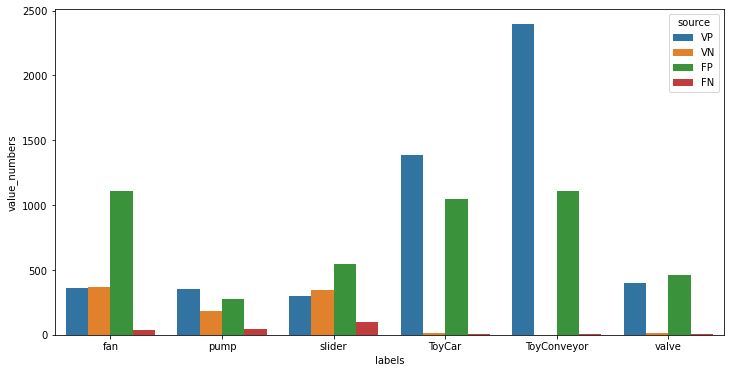

In [72]:
colonne = result_rf.machine_type.unique().tolist()

dict_analyse = {}
VP, VN, FP, FN = [], [], [], []
for col in colonne:
    VP.append (result_rf [(result_rf['condition'] == "normal" ) & (result_rf['Predict_condition'] == "normal") & (result_rf['machine_type'] == col) ].shape[0])
    VN.append (result_rf [(result_rf['condition'] == "anomaly" ) & (result_rf['Predict_condition'] == "anomaly") & (result_rf['machine_type'] == col) ].shape[0])
    FP.append (result_rf [(result_rf['condition'] == "anomaly" ) & (result_rf['Predict_condition'] == "normal") & (result_rf['machine_type'] == col) ].shape[0])
    FN.append (result_rf [(result_rf['condition'] == "normal" ) & (result_rf['Predict_condition'] == "anomaly") & (result_rf['machine_type'] == col) ].shape[0])
    
dict_analyse ['labels'] = colonne
dict_analyse ['VP'] = VP
dict_analyse ['VN'] = VN
dict_analyse ['FP'] = FP
dict_analyse ['FN'] = FN

analyse = pd.DataFrame(dict_analyse)

columns = ["labels", "VP", "VN", "FP", "FN"]
analyse_melted = pd.melt(analyse, id_vars=columns[0], var_name="source", value_name="value_numbers")
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x=columns[0], y="value_numbers", hue="source", data=analyse_melted)
plt.show()